# Text Mining & Search
Authors
- Alexandre Crivellari
- Andrea Muscio


# Introduction

**Text mining** is a powerful and versatile technique for analyzing and interpreting large amounts of unstructured textual data. In the digital age, with the explosion of online content, the ability to efficiently analyze and understand text has become crucial across various fields, including politics, marketing, healthcare, and finance. Text mining enables the transformation of raw text into structured data, allowing for the identification of patterns, extraction of knowledge, and evidence-based decision-making.

In this project, we aim to explore and apply different text mining methodologies using the **LIAR dataset**. This dataset is particularly interesting and complex as it contains over 12,000 political statements made by public figures in the United States, each labeled as true, partially true, mostly-true, barely-true, half-true, false, pants-fire among other categories. Analyzing these statements can provide significant insights into political language and the dissemination of information, helping to identify trends in the truthfulness of public figures' statements.

The main tasks of this project are twofold:

1. **Topic Modeling**: This approach allows us to automatically discover the latent themes present in the corpus of statements. Topic modeling not only facilitates the understanding of the main topics discussed in the data but also helps to identify how different topics are distributed between true and false statements.

2. **Text Classification**: In this task, the goal is to build a model capable of distinguishing between true and false statements. Text classification is a crucial step in developing automated fact-checking systems, which can be used to combat misinformation and improve transparency in public discourse.

Using the LIAR dataset, this project will explore the effectiveness of topic modeling and text classification techniques in analyzing political statements, highlighting the potential of text mining in extracting valuable knowledge from complex textual data.


# Workspace setting

## Dependencies

In [2]:
# Uncomment if needed to install the required packages

# %pip install pandas numpy matplotlib seaborn scikit-learn scipy
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install captum
# %pip install gensim
# %pip install nltk gensim pyLDAvis
# %pip install wordcloud

## Libraries

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F
from gensim.models import CoherenceModel

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset upload and exploration

In [4]:
# Define the column names
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
           'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
           'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Read the TSV files
train_df = pd.read_csv('train.tsv', sep='\t', names=columns)
valid_df = pd.read_csv('valid.tsv', sep='\t', names=columns)
test_df = pd.read_csv('test.tsv', sep='\t', names=columns)

In [5]:
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


In [6]:
# Check for missing values
print(train_df.isnull().sum())

id                         0
label                      0
statement                  0
subject                    2
speaker                    2
job_title               2898
state_info              2210
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
dtype: int64


In [7]:
# Remove 'job_title' and 'state_info' columns from all datasets
columns_to_remove = ['job_title', 'state_info']

train_df = train_df.drop(columns=columns_to_remove)
valid_df = valid_df.drop(columns=columns_to_remove)
test_df = test_df.drop(columns=columns_to_remove)

# Verify the columns have been removed
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'party_affiliation',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_on_fire_counts', 'context'],
      dtype='object')


In [8]:
# Check for missing values
print(train_df.isnull().sum())

# Handle missing values
categorical_columns = ['subject', 'speaker', 'party_affiliation', 'context']
numeric_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

# For categorical columns, fill with 'Unknown' instead of 'unknown'
for col in categorical_columns:
    train_df[col] = train_df[col].fillna('Unknown')
    valid_df[col] = valid_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

# For numeric columns, ensure they are numeric and fill with median
for col in numeric_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    valid_df[col] = pd.to_numeric(valid_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    
    median_value = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_value)
    valid_df[col] = valid_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

id                        0
label                     0
statement                 0
subject                   2
speaker                   2
party_affiliation         2
barely_true_counts        2
false_counts              2
half_true_counts          2
mostly_true_counts        2
pants_on_fire_counts      2
context                 102
dtype: int64


In [9]:
# Define the custom order for the labels
label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

# Convert 'label' column to a categorical type with the specified order
train_df['label'] = pd.Categorical(train_df['label'], categories=label_order, ordered=True)

train_df.head()

,id,label,statement,subject,speaker,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


label
half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: proportion, dtype: float64


C:\Users\alexc\AppData\Local\Temp\ipykernel_28948\939147369.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_df, order=label_order, palette=palette)


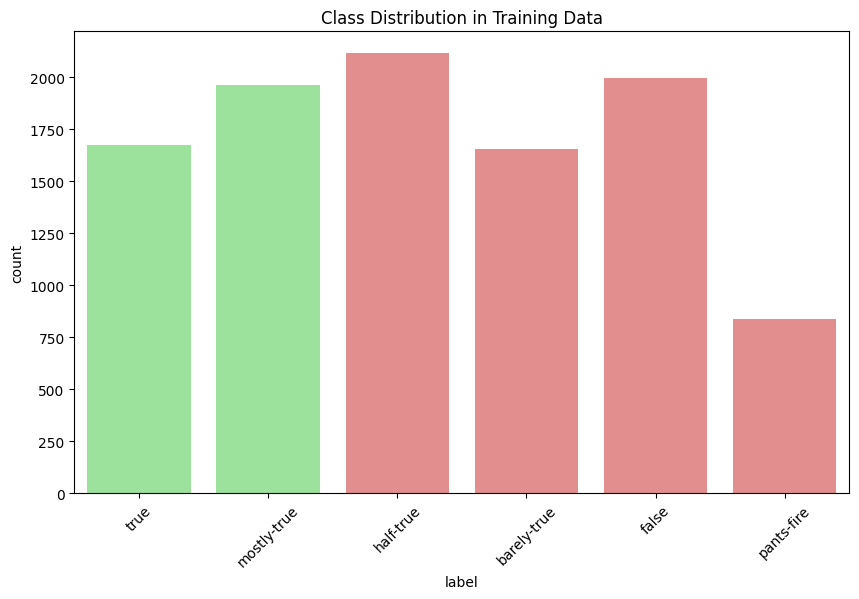

In [10]:
# Encode labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
valid_df['label_encoded'] = le.transform(valid_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

# Display class distribution
print(train_df['label'].value_counts(normalize=True))

# Define custom colors for the plot: green for true and mostly-true, light red for others
palette = {
    'true': 'lightgreen',
    'mostly-true': 'lightgreen',
    'half-true': 'lightcoral',
    'barely-true': 'lightcoral',
    'false': 'lightcoral',
    'pants-fire': 'lightcoral'
}

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df, order=label_order, palette=palette)
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [11]:
# Create a feature for statement length
train_df['statement_length'] = train_df['statement'].str.len()
valid_df['statement_length'] = valid_df['statement'].str.len()
test_df['statement_length'] = test_df['statement'].str.len()

# Aggregate count features
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                 'mostly_true_counts', 'pants_on_fire_counts']

train_df['total_statements'] = train_df[count_columns].sum(axis=1)
valid_df['total_statements'] = valid_df[count_columns].sum(axis=1)
test_df['total_statements'] = test_df[count_columns].sum(axis=1)

Class distribution in training set:
binary_label
False    0.644727
True     0.355273
Name: proportion, dtype: float64

Class distribution in validation set:
binary_label
False    0.672897
True     0.327103
Name: proportion, dtype: float64

Class distribution in test set:
binary_label
False    0.64562
True     0.35438
Name: proportion, dtype: float64


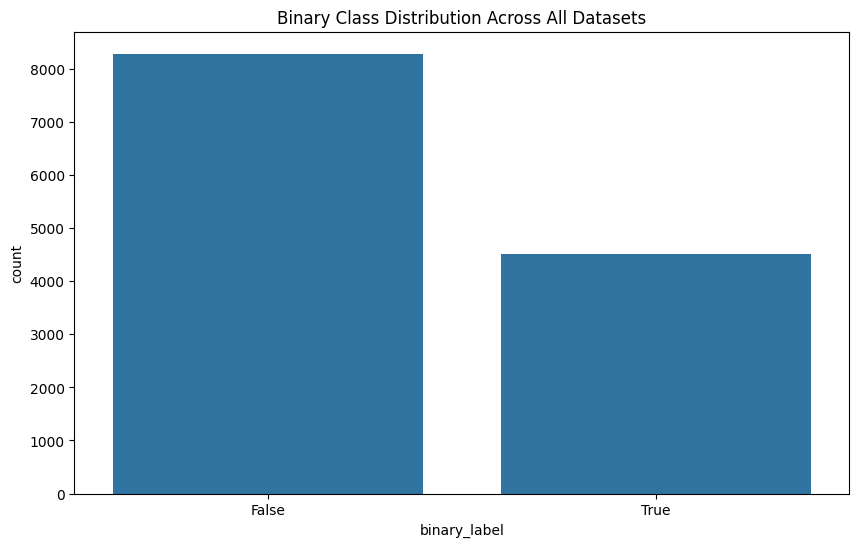

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Binarization function for labels:
# 'true' and 'mostly-true' are considered True
# 'half-true', 'barely-true', 'false', and 'pants-fire' are considered False

def binarize_labels(label):
    if label in ['true', 'mostly-true']:
        return 'True'
    else:
        return 'False'

# Apply binary labeling to all datasets
train_df['binary_label'] = train_df['label'].apply(binarize_labels)
valid_df['binary_label'] = valid_df['label'].apply(binarize_labels)
test_df['binary_label'] = test_df['label'].apply(binarize_labels)

# Encode binary labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['binary_label'])
valid_df['label_encoded'] = le.transform(valid_df['binary_label'])
test_df['label_encoded'] = le.transform(test_df['binary_label'])

# Display class distribution
print("Class distribution in training set:")
print(train_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in validation set:")
print(valid_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in test set:")
print(test_df['binary_label'].value_counts(normalize=True))

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='binary_label', data=pd.concat([train_df, valid_df, test_df]))
plt.title('Binary Class Distribution Across All Datasets')
plt.show()

In [13]:
# Print some sample rows to verify the transformation
print("\nSample rows from the training set:")
print(train_df[['statement', 'label', 'binary_label', 'label_encoded']].head(10))


Sample rows from the training set:
                                           statement        label  \
0  Says the Annies List political group supports ...        false   
1  When did the decline of coal start? It started...    half-true   
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true   
3  Health care reform legislation is likely to ma...        false   
4  The economic turnaround started at the end of ...    half-true   
5  The Chicago Bears have had more starting quart...         true   
6  Jim Dunnam has not lived in the district he re...  barely-true   
7  I'm the only person on this stage who has work...    half-true   
8  However, it took $19.5 million in Oregon Lotte...    half-true   
9  Says GOP primary opponents Glenn Grothman and ...  mostly-true   

  binary_label  label_encoded  
0        False              0  
1        False              0  
2         True              1  
3        False              0  
4        False              0  
5         Tr

In [14]:
# Save the label encoder
import joblib
joblib.dump(le, 'binary_label_encoder.joblib')
print("\nLabel Encoder saved as 'binary_label_encoder.joblib'")


Label Encoder saved as 'binary_label_encoder.joblib'


## Wordcloud exploration

### Based on True/False Statement

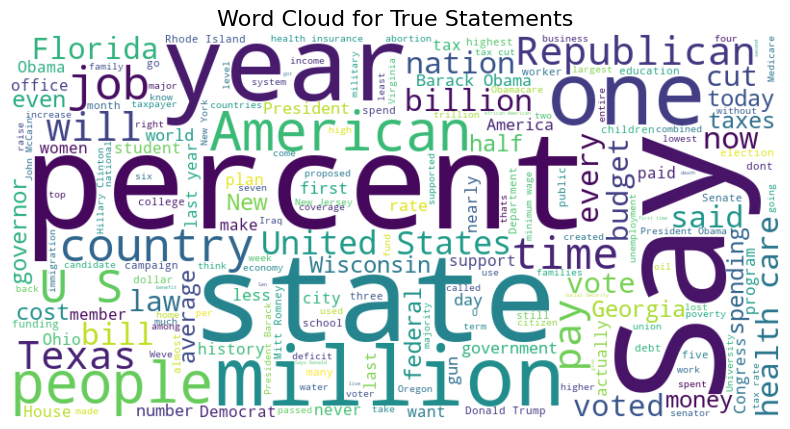

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create and display a word cloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Filter the dataset based on binary_label
true_text = ' '.join(train_df[train_df['binary_label'] == "True"]['statement'].astype(str))
false_text = ' '.join(train_df[train_df['binary_label'] == "False"]['statement'].astype(str))

# Generate word cloud for True statements
create_wordcloud(true_text, "Word Cloud for True Statements")

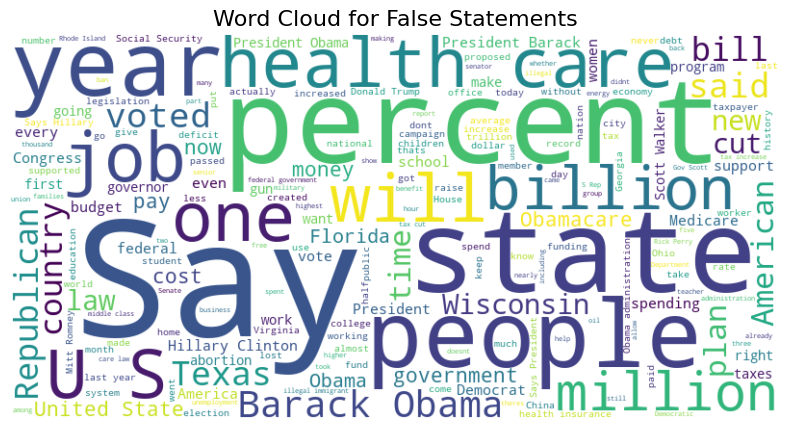

In [16]:
# Generate word cloud for False statements
create_wordcloud(false_text, "Word Cloud for False Statements")

### Based on Speaker

In [17]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the labels that are considered "True"
true_labels = ['true', 'mostly-true']

# Calculate the percentage of "True" statements for each speaker
def calculate_true_percentage(speaker, df):
    speaker_df = df[df['speaker'] == speaker]
    true_count = speaker_df[speaker_df['label'].isin(true_labels)].shape[0]
    total_count = speaker_df.shape[0]
    if total_count == 0:  # To avoid division by zero
        return 0
    return (true_count / total_count) * 100

# List of speakers
speakers = ['barack-obama', 'donald-trump', 'hillary-clinton', 'mitt-romney']

# Dictionary to store the percentage of True statements for each speaker
true_percentages = {speaker: calculate_true_percentage(speaker, train_df) for speaker in speakers}

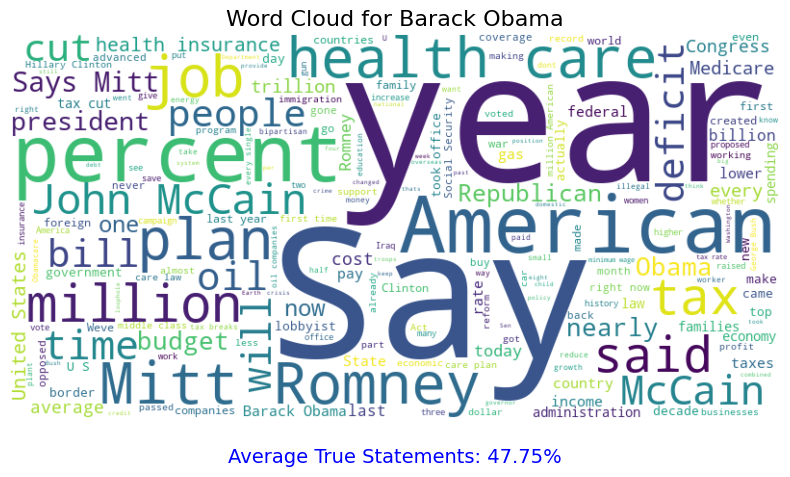

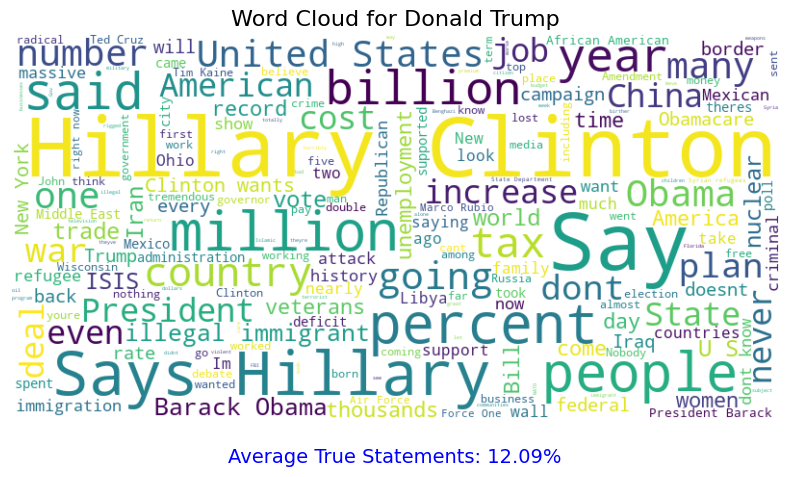

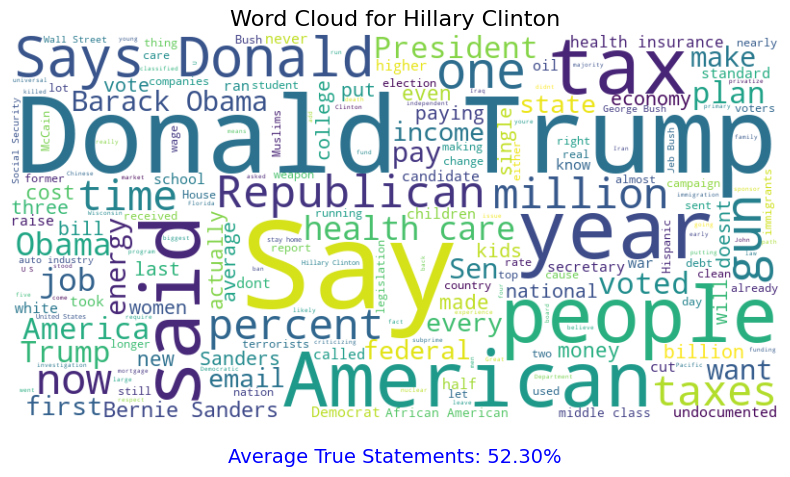

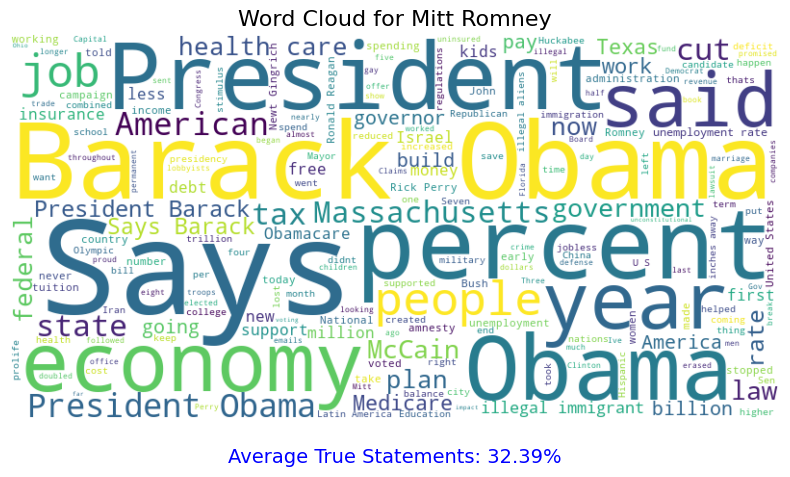

In [18]:
# Function to create and display a word cloud with an annotation
def create_wordcloud_with_annotation(text, title, percentage):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # Add title and annotation
    plt.title(title, fontsize=16)
    annotation = f'Average True Statements: {percentage:.2f}%'
    plt.text(0.5, -0.1, annotation, fontsize=14, ha='center', va='center', transform=plt.gca().transAxes, color='blue')
    
    plt.show()

# Generate word clouds with annotations for each speaker
for speaker in speakers:
    # Filter statements by the current speaker
    speaker_statements = train_df[train_df['speaker'] == speaker]['statement'].astype(str)
    
    # Concatenate all statements into a single string
    speaker_text = ' '.join(speaker_statements)
    
    # Get the percentage of True statements
    percentage = true_percentages[speaker]
    
    # Generate and display the word cloud with annotation
    create_wordcloud_with_annotation(speaker_text, f'Word Cloud for {speaker.replace("-", " ").title()}', percentage)


# Task 1 - Text Classification (Binary)

### Traditional ML Technique - Random Forest Classifier

In [19]:
# Text preprocessing function
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned_tokens)

# Apply text preprocessing
train_df['cleaned_statement'] = train_df['statement'].apply(preprocess_text)
valid_df['cleaned_statement'] = valid_df['statement'].apply(preprocess_text)
test_df['cleaned_statement'] = test_df['statement'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Prepare data for Traditional ML (Random Forest)
# TF-IDF Vectorization with a fixed number of features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['cleaned_statement'])
X_valid_tfidf = tfidf.transform(valid_df['cleaned_statement'])
X_test_tfidf = tfidf.transform(test_df['cleaned_statement'])

# Prepare numerical features
numerical_features = ['statement_length', 'total_statements', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[numerical_features])
X_valid_num = scaler.transform(valid_df[numerical_features])
X_test_num = scaler.transform(test_df[numerical_features])

# Combine TF-IDF and numerical features
X_train = np.hstack((X_train_tfidf.toarray(), X_train_num))
X_valid = np.hstack((X_valid_tfidf.toarray(), X_valid_num))
X_test = np.hstack((X_test_tfidf.toarray(), X_test_num))

y_train = train_df['label_encoded']
y_valid = valid_df['label_encoded']
y_test = test_df['label_encoded']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [21]:
# Train the model
def train_with_progress(X, y, n_estimators=100):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X, y)
    return rf_model

print("Training Random Forest model...")
rf_model = train_with_progress(X_train_resampled, y_train_resampled)

Training Random Forest model...


In [22]:
# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
        'Score': [accuracy, precision, recall, f1, auc_roc]
    })
    
    return results, y_pred, y_pred_proba

# Evaluate the model
print("Evaluating the model...")
results, y_pred, y_test_pred = evaluate_model(rf_model, X_test, y_test)
print(results)

# Print feature counts for debugging
print(f"Number of features in training data: {X_train_resampled.shape[1]}")
print(f"Number of features in test data: {X_test.shape[1]}")

Evaluating the model...
      Metric     Score
0   Accuracy  0.726914
1  Precision  0.652819
2     Recall  0.489978
3   F1 Score  0.559796
4    AUC-ROC  0.769109
Number of features in training data: 5007
Number of features in test data: 5007



Generating performance visualizations...


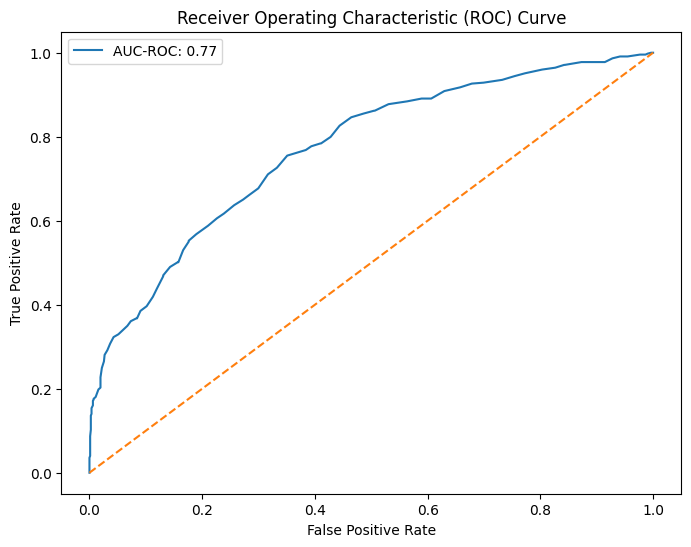

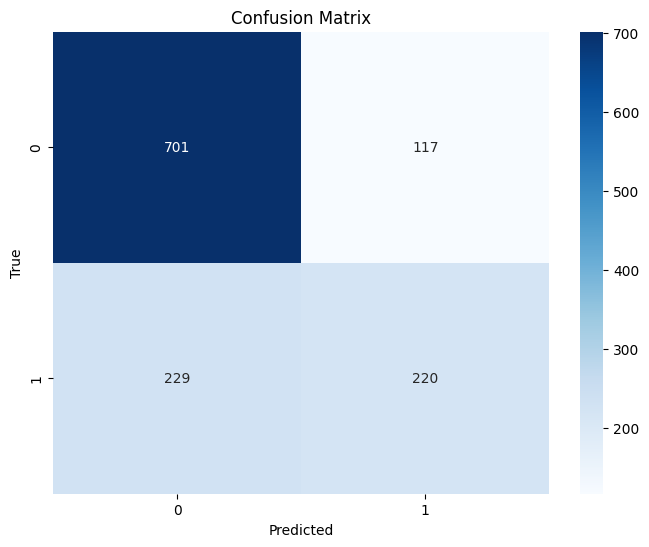

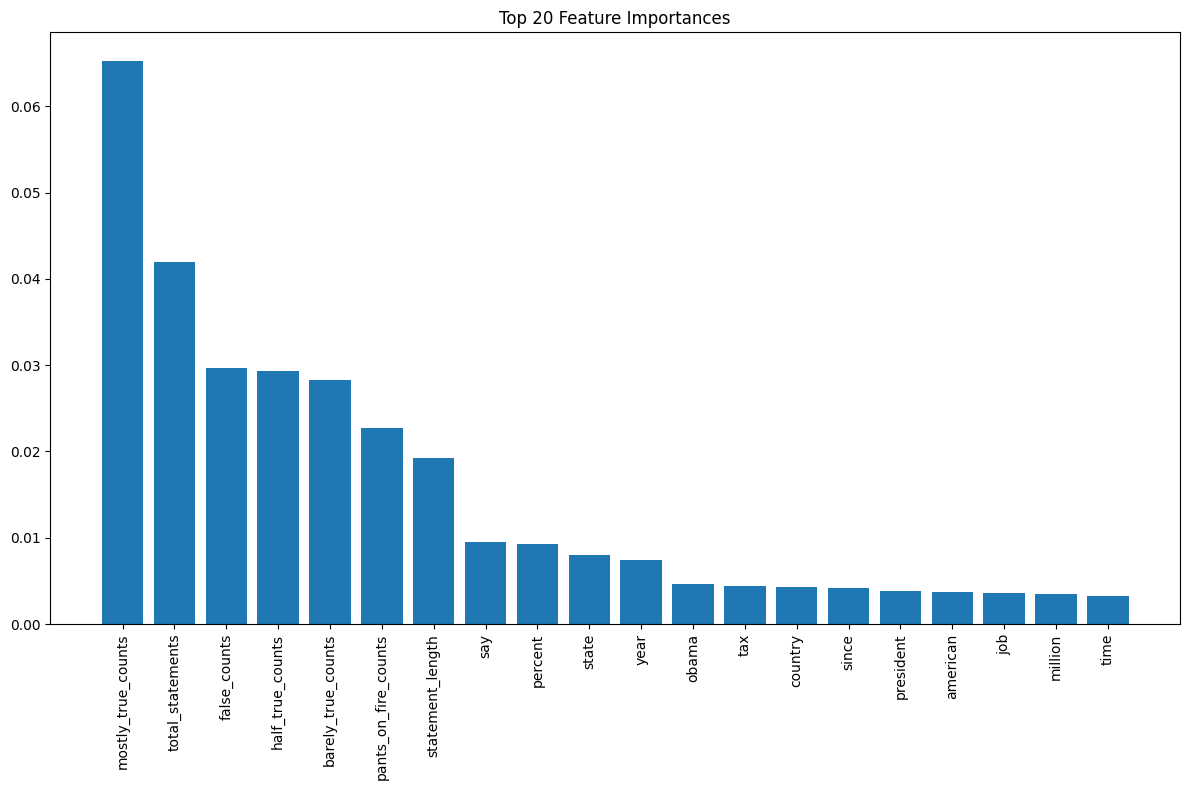

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# ROC Curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_score(y_true, y_pred_proba):.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Feature Importance
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Top {top_n} Feature Importances")
    plt.bar(range(top_n), importances[indices])
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# After model evaluation, add these lines:
print("\nGenerating performance visualizations...")

# Plot ROC curve
plot_roc_curve(y_test, y_test_pred)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot feature importance
feature_names = tfidf.get_feature_names_out().tolist() + numerical_features
plot_feature_importance(rf_model, feature_names)

In [24]:
import joblib

def save_model(model, filename='random_forest_model.joblib'):
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# Save the model
save_model(rf_model)

Model saved as random_forest_model.joblib


### Deep Learning Model - RoBERTa

In [25]:
# Read the TSV files
train_df = pd.read_csv('train.tsv', sep='\t', names=columns)
valid_df = pd.read_csv('valid.tsv', sep='\t', names=columns)
test_df = pd.read_csv('test.tsv', sep='\t', names=columns)

# Step 2: Preprocess the datasets for RoBERTa

def binarize_labels(label):
    if label in ['true', 'mostly-true']:
        return 'True'
    else:
        return 'False'

# Apply binary labeling to all datasets
train_df['binary_label'] = train_df['label'].apply(binarize_labels)
valid_df['binary_label'] = valid_df['label'].apply(binarize_labels)
test_df['binary_label'] = test_df['label'].apply(binarize_labels)

# Encode binary labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['binary_label'])
valid_df['label_encoded'] = le.transform(valid_df['binary_label'])
test_df['label_encoded'] = le.transform(test_df['binary_label'])

In [26]:
# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize and encode the statements
max_length = 128  # You can adjust this based on your data

def encode_statements(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = encode_statements(train_df['statement'].tolist())
valid_encodings = encode_statements(valid_df['statement'].tolist())
test_encodings = encode_statements(test_df['statement'].tolist())

# Create PyTorch datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], 
                              torch.tensor(train_df['label_encoded'].tolist()))
valid_dataset = TensorDataset(valid_encodings['input_ids'], valid_encodings['attention_mask'], 
                              torch.tensor(valid_df['label_encoded'].tolist()))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], 
                             torch.tensor(test_df['label_encoded'].tolist()))

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
# Set device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label_encoded']), y=train_df['label_encoded'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [29]:
# Step 3: Train the model

# Set up the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

# Set up the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
import time

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0
    start_time = time.time()

    # Create a tqdm progress bar for the training loader
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs} [Train]',
                      total=len(train_loader), unit='batch')

    for batch in train_pbar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        # Apply class weights to the loss
        loss = F.cross_entropy(outputs.logits, labels, weight=class_weights)
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        elapsed_time = time.time() - start_time
        batch_time = elapsed_time / (train_pbar.n + 1)
        remaining_time = batch_time * (len(train_loader) - train_pbar.n - 1)
        train_pbar.set_postfix({
            'loss': f'{train_loss / (train_pbar.n + 1):.4f}',
            'elapsed': f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}',
            'remaining': f'{time.strftime("%H:%M:%S", time.gmtime(remaining_time))}',
            'total': f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time + remaining_time))}'
        })

    train_pbar.close()
    
    # Validation
    model.eval()
    valid_loss = 0
    valid_pbar = tqdm(valid_loader, desc=f'Epoch {epoch + 1}/{epochs} [Valid]', 
                      total=len(valid_loader), unit='batch')
    
    with torch.no_grad():
        for batch in valid_pbar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            valid_loss += outputs.loss.item()
            
            # Update the progress bar
            valid_pbar.set_postfix({'loss': f'{valid_loss / (valid_pbar.n + 1):.4f}'})
    
    valid_pbar.close()
    
    print(f'Epoch {epoch + 1}/{epochs}:')
    print(f'Train Loss: {train_loss / len(train_loader):.4f}')
    print(f'Validation Loss: {valid_loss / len(valid_loader):.4f}')
    print(f'Epoch Time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))}')
    print()

print("Training completed!")

Epoch 1/3 [Valid]: 100%|██████████| 81/81 [00:01<00:00, 70.79batch/s, loss=0.6148]


Epoch 1/3:
Train Loss: 0.6806
Validation Loss: 0.6148
Epoch Time: 00:00:53



Epoch 2/3 [Valid]: 100%|██████████| 81/81 [00:01<00:00, 67.36batch/s, loss=0.6386]


Epoch 2/3:
Train Loss: 0.6453
Validation Loss: 0.6149
Epoch Time: 00:00:54



Epoch 3/3 [Valid]: 100%|██████████| 81/81 [00:01<00:00, 71.07batch/s, loss=0.6224]

Epoch 3/3:
Train Loss: 0.5919
Validation Loss: 0.6147
Epoch Time: 00:00:53

Training completed!


In [ ]:
# Save the model
torch.save(model.state_dict(), 'roberta_binary_classifier.pt')
print("Model saved as 'roberta_binary_classifier.pt'")

Model saved as 'roberta_binary_classifier.pt'


C:\Users\alexc\AppData\Local\Temp\ipykernel_66100\244060633.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('roberta_binary_classifier.

Test Accuracy: 0.6117
Precision: 0.4587
Recall: 0.5323
F1-score: 0.4928
AUC-ROC: 0.5938


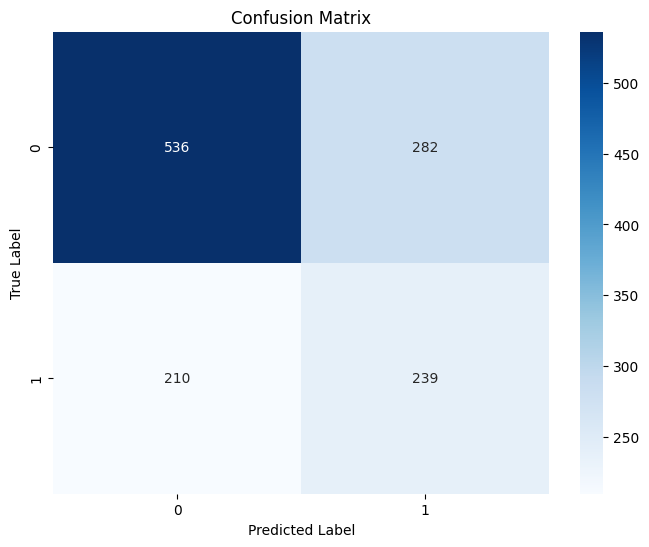

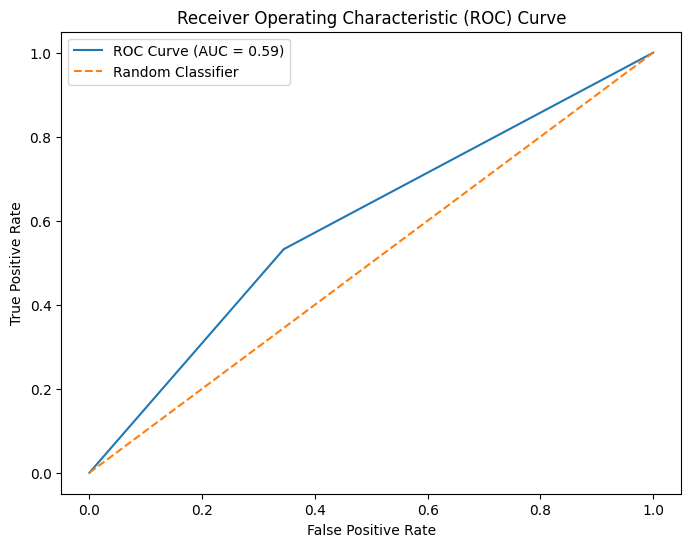

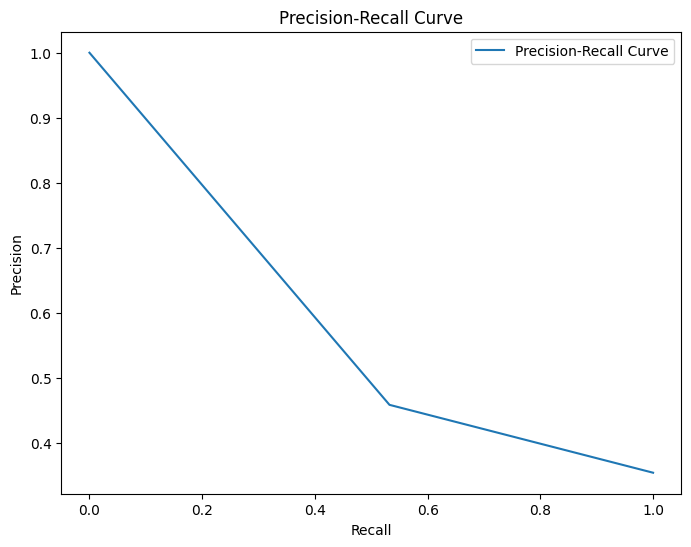

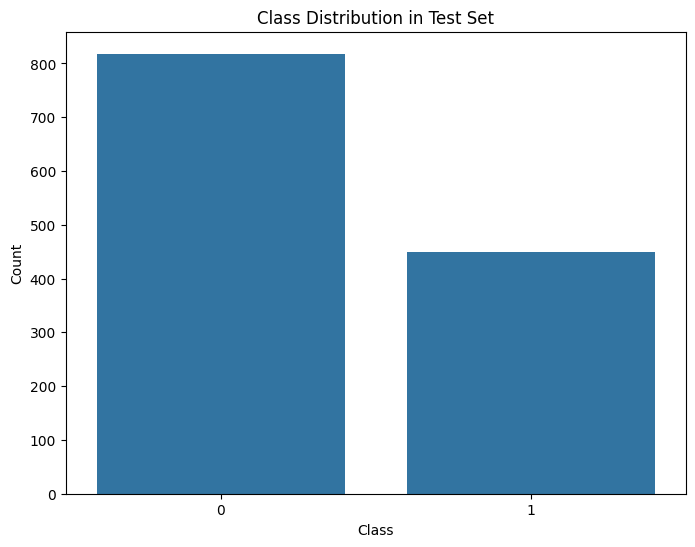

In [31]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 4. Evaluate the model against the test set

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# Load the saved model
model.load_state_dict(torch.load('roberta_binary_classifier.pt'))
model.to(device)

# Evaluate on test set
test_predictions, test_true_labels = evaluate_model(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(test_true_labels, test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='binary')
auc_roc = roc_auc_score(test_true_labels, test_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# 5. Produce graphs for showing model performance

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, _ = precision_recall_curve(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=test_true_labels)
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Save the evaluation results
results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc_roc
}

In [32]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_predictions.extend(preds)
            all_true_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())
    
    y_pred = np.array(all_predictions)
    y_test = np.array(all_true_labels)
    y_pred_proba = np.array(all_probabilities)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
        'Score': [accuracy, precision, recall, f1, auc_roc]
    })
    
    return results, y_pred, y_pred_proba

# Load the saved model
model.load_state_dict(torch.load('roberta_binary_classifier.pt'))
model.to(device)

# Evaluate the model
print("Evaluating the RoBERTa model...")
results, y_pred, y_test_pred = evaluate_model(model, test_loader, device)
print(results)

C:\Users\alexc\AppData\Local\Temp\ipykernel_66100\1573148793.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('roberta_binary_classifier

Evaluating the RoBERTa model...


Evaluating: 100%|██████████| 80/80 [00:02<00:00, 38.97it/s]

      Metric     Score
0   Accuracy  0.611681
1  Precision  0.458733
2     Recall  0.532294
3   F1 Score  0.492784
4    AUC-ROC  0.646017


### Model Comparison

Notes on why Roberta performs worse:

Dataset size: If the dataset is relatively small, traditional ML models like Random Forest can sometimes perform better than deep learning models, which typically require larger datasets to shine.

Feature engineering: The Random Forest model benefits from manually engineered features, which might capture important aspects of the data that the RoBERTa model hasn't learned to identify.

Task simplicity: If the classification task is relatively simple and doesn't require deep understanding of language nuances, a simpler model like Random Forest might be sufficient.

Hyperparameter tuning: The Random Forest model might be better tuned for this specific task compared to the current RoBERTa implementation.

Overfitting: The RoBERTa model, being more complex, might be overfitting to the training data, especially if the dataset is small.

# Task 2 - Topic Modelling

# Latent Dirichlet Allocation (LDA) in Topic Modeling

**Latent Dirichlet Allocation (LDA)** is a generative probabilistic model used for identifying the underlying topics in a collection of documents. In the context of topic modeling, LDA assumes that each document is a mixture of various topics, and each topic is characterized by a distribution over words. The goal of LDA is to discover the hidden thematic structure in the corpus and to assign each word in a document to one of the topics.

## How LDA Works

LDA operates under the assumption that documents are generated through a probabilistic process:

1. **Topic Distribution for Each Document**:
    - For each document in the corpus, LDA assumes a Dirichlet distribution over a fixed number of topics. This distribution is represented by a vector $\theta_d$, where $\theta_d$ indicates the proportion of each topic in the document $d$.
    
2. **Word Distribution for Each Topic**:
    - Each topic $z$ is represented by a multinomial distribution over words, denoted as $\phi_z$. This distribution is also drawn from a Dirichlet prior, indicating the probability of each word in the vocabulary appearing in the topic.

3. **Document Generation Process**:
    - For each word in a document, LDA first selects a topic $z$ according to the topic distribution $\theta_d$ for that document. Then, it generates the word by sampling from the word distribution $\phi_z$ corresponding to the chosen topic.

4. **Inference**:
    - The challenge in LDA is to reverse this generative process: given a collection of documents, the model infers the most likely set of topics, the topic distribution for each document, and the word distribution for each topic. This is typically done using approximation techniques like Variational Inference or Gibbs Sampling.
    
## Applying LDA to Topic Modeling

When applied to topic modeling, LDA helps in discovering the hidden thematic structure in a large corpus of text. Here's how LDA can be utilized:

- **Identifying Topics**:
    - By running LDA on a set of documents, we can uncover a predefined number of topics, where each topic is a distribution over words. For instance, in a collection of news articles, LDA might identify topics such as "politics," "technology," or "health," each represented by a set of keywords that frequently co-occur in the context of that topic.

- **Document Representation**:
    - After fitting the LDA model, each document in the corpus can be represented as a mixture of these topics. For example, an article might be 70% about "politics" and 30% about "health," providing a more nuanced understanding of the content than just a single label.

- **Topic Interpretation**:
    - The output of LDA includes the top words associated with each topic, which can be interpreted by a human to assign labels or categories to the topics. This interpretation is crucial for understanding the dominant themes in the corpus and how different topics are distributed across documents.

## Benefits of Using LDA

- **Unsupervised Learning**:
    - LDA is an unsupervised learning algorithm, meaning it does not require labeled data. It automatically discovers topics within the text, making it a powerful tool for exploring and understanding large, unstructured datasets.

- **Scalability**:
    - LDA is scalable and can handle large corpora, making it suitable for applications ranging from social media analysis to news categorization and beyond.

- **Flexibility**:
    - The model's flexibility allows it to capture a wide range of topics in diverse domains, making it applicable in various fields such as marketing, politics, and literature analysis.



In [19]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Dataset preprocessing for LDA

In [20]:
# Display the first few rows
print(train_df.head())

# Focus on the 'statement' column for topic modeling
statements = train_df['statement'].astype(str)

           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                              subject         speaker party_affiliation  \
0                            abortion    dwayne-bohac        republican   
1  energy,history,job-accomplishments  scott-surovell          democrat   
2                      foreign-policy    barack-obama          democrat   
3                         health-care    blog-posting              none   
4                        economy,jobs   charlie-crist          democrat   

   barely_true_counts  false_counts  half_true_counts  mostly_

In [21]:
# Initialize the stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text.lower())
    # Remove stopwords and punctuation, and lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return words

# Apply preprocessing to all statements
processed_statements = statements.apply(preprocess_text)

# View the processed text
print(processed_statements.head())

0    [say, annies, list, political, group, support,...
1    [decline, coal, start, started, natural, gas, ...
2    [hillary, clinton, agrees, john, mccain, votin...
3    [health, care, reform, legislation, likely, ma...
4           [economic, turnaround, started, end, term]
Name: statement, dtype: object


In [22]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_statements)

# Filter out extreme values in the dictionary (optional)
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create a Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in processed_statements]

# Display a sample of the corpus
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1)]]


## Generic study

### Topic Modeling

In [65]:
# Set the number of topics
num_topics = 5

# Build the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=42,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Display the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic) 

(0, '0.087*"say" + 0.049*"percent" + 0.042*"tax" + 0.021*"million" + 0.020*"people" + 0.019*"would" + 0.016*"billion" + 0.016*"bill" + 0.016*"cut" + 0.015*"texas"')
(1, '0.092*"year" + 0.030*"one" + 0.023*"get" + 0.023*"last" + 0.021*"democrat" + 0.019*"money" + 0.019*"spending" + 0.018*"like" + 0.016*"illegal" + 0.015*"administration"')
(2, '0.088*"state" + 0.049*"job" + 0.029*"new" + 0.023*"wisconsin" + 0.019*"united" + 0.017*"rate" + 0.017*"clinton" + 0.016*"gov" + 0.016*"america" + 0.013*"cost"')
(3, '0.035*"since" + 0.032*"school" + 0.028*"florida" + 0.027*"budget" + 0.026*"plan" + 0.026*"want" + 0.025*"public" + 0.020*"security" + 0.020*"number" + 0.020*"governor"')
(4, '0.044*"obama" + 0.037*"health" + 0.036*"president" + 0.034*"care" + 0.024*"time" + 0.023*"barack" + 0.020*"voted" + 0.016*"insurance" + 0.014*"dollar" + 0.014*"party"')


### Topics Visulization

In [69]:
# Visualize the topics using pyLDAvis
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

# Save the visualization to an HTML file (optional)
# pyLDAvis.save_html(lda_vis, 'lda_topics.html')

In [44]:
# Assign the most likely topic to each document
def assign_topic(lda_model, corpus):
    topics = []
    for bow in corpus:
        topic_distribution = lda_model.get_document_topics(bow)
        topics.append(sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0])
    return topics

train_df['topic'] = assign_topic(lda_model, corpus)
print(train_df[['statement', 'topic']].head())

                                           statement  topic
0  Says the Annies List political group supports ...      0
1  When did the decline of coal start? It started...      1
2  Hillary Clinton agrees with John McCain "by vo...      2
3  Health care reform legislation is likely to ma...      4
4  The economic turnaround started at the end of ...      0


In [45]:
# Save the dataframe with the assigned topics
train_df.to_csv('train_with_topics.csv', index=False)

## Evaluation

### Perplexity and Coherence in Topic Modeling

**Perplexity** is a measure of how well a probabilistic model predicts a sample. In the context of topic modeling, perplexity is used to evaluate the quality of the LDA model by estimating how accurately the model can predict unseen data. It is calculated as the inverse of the geometric mean of the likelihood of a test set, given the model. A lower perplexity score indicates a better generalization performance of the model.

**Coherence** measures the interpretability of the topics generated by a model. It evaluates how semantically consistent the top words within each topic are. Coherence is typically calculated based on the degree of semantic similarity between words in the topic. Higher coherence scores indicate that the topics are more interpretable and meaningful, making them more useful for practical applications.


#### Perplexity

In [60]:
# Calculate the perplexity score
log_perplexity = lda_model.log_perplexity(corpus)
perplexity = np.exp(-log_perplexity)  # Note the negative sign
print(f'Perplexity: {perplexity}')

Perplexity: 697.0166369846058


#### Coherence

In [61]:
from gensim.models import CoherenceModel

# Calculate coherence score
def calculate_topic_coherence(lda_model, texts, dictionary):
    topic_coherence = []
    for topic_id in range(lda_model.num_topics):
        top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
        cm = CoherenceModel(topics=[top_words], texts=texts, dictionary=dictionary, coherence='c_v')
        topic_coherence.append(cm.get_coherence())
    return topic_coherence

# Calculate coherence for each topic
topic_coherences = calculate_topic_coherence(lda_model, processed_statements, dictionary)

# Print coherence for each topic
for topic_id, coherence in enumerate(topic_coherences):
    print(f"Coherence for Topic {topic_id}: {coherence}")

# Calculate and print the average coherence
average_coherence = np.mean(topic_coherences)
print(f"Average Topic Coherence: {average_coherence}")

# For comparison, calculate the overall model coherence as before
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_statements, dictionary=dictionary, coherence='c_v')
overall_coherence = coherence_model_lda.get_coherence()
print(f"Overall Model Coherence: {overall_coherence}")

Coherence for Topic 0: 0.4996125271865095
Coherence for Topic 1: 0.4018039684689739
Coherence for Topic 2: 0.5038490276271455
Coherence for Topic 3: 0.28501422739107146
Coherence for Topic 4: 0.39921419097371114
Average Topic Coherence: 0.41789878832948224
Overall Model Coherence: 0.27832240099283945


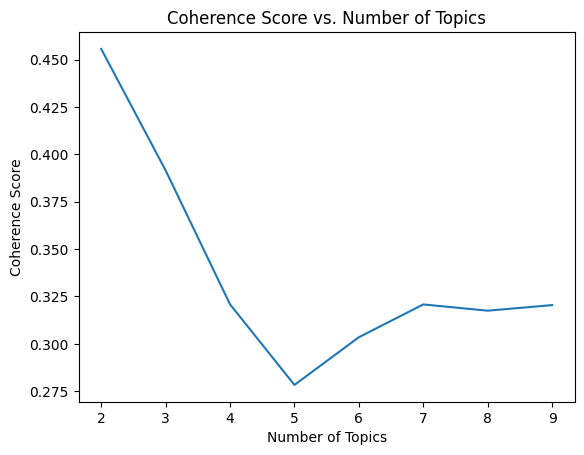

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=42,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Run the function over a range of topics
start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_statements, start=start, limit=limit, step=step)

# Plot coherence values
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()


## Topics between True and False Statements

### Preprocessing

In [49]:
true_labels = ['true', 'mostly-true'] 
false_labels = ['false', 'pants-fire', 'barely-true']

# Filter the dataset for True statements
true_statements = train_df[train_df['label'].isin(true_labels)]['statement'].astype(str)

# Filter the dataset for False statements
false_statements = train_df[train_df['label'].isin(false_labels)]['statement'].astype(str)

In [50]:
# Reuse the preprocess_text function from earlier

# Preprocess the True statements
processed_true_statements = true_statements.apply(preprocess_text)

# Preprocess the False statements
processed_false_statements = false_statements.apply(preprocess_text)

In [51]:
# Create a dictionary and corpus for True statements
true_dictionary = corpora.Dictionary(processed_true_statements)
true_dictionary.filter_extremes(no_below=15, no_above=0.5)
true_corpus = [true_dictionary.doc2bow(text) for text in processed_true_statements]

# Create a dictionary and corpus for False statements
false_dictionary = corpora.Dictionary(processed_false_statements)
false_dictionary.filter_extremes(no_below=15, no_above=0.5)
false_corpus = [false_dictionary.doc2bow(text) for text in processed_false_statements]


### Topic Modeling

In [52]:
# Set the number of topics
num_topics = 5

# Build the LDA model for True statements
lda_model_true = gensim.models.LdaModel(corpus=true_corpus,
                                        id2word=true_dictionary,
                                        num_topics=num_topics,
                                        random_state=42,
                                        update_every=1,
                                        chunksize=100,
                                        passes=10,
                                        alpha='auto',
                                        per_word_topics=True)

# Build the LDA model for False statements
lda_model_false = gensim.models.LdaModel(corpus=false_corpus,
                                         id2word=false_dictionary,
                                         num_topics=num_topics,
                                         random_state=42,
                                         update_every=1,
                                         chunksize=100,
                                         passes=10,
                                         alpha='auto',
                                         per_word_topics=True)


### Topics Visualization

In [53]:
# Display topics for True statements
print("Topics for True statements:")
true_topics = lda_model_true.print_topics(num_words=10)
for topic in true_topics:
    print(topic)

# Display topics for False statements
print("\nTopics for False statements:")
false_topics = lda_model_false.print_topics(num_words=10)
for topic in false_topics:
    print(topic)


Topics for True statements:
(0, '0.044*"nation" + 0.035*"want" + 0.029*"senate" + 0.026*"woman" + 0.026*"illegal" + 0.025*"gun" + 0.023*"back" + 0.022*"money" + 0.022*"never" + 0.019*"amendment"')
(1, '0.109*"year" + 0.106*"tax" + 0.041*"people" + 0.037*"pay" + 0.035*"would" + 0.026*"get" + 0.024*"even" + 0.022*"today" + 0.022*"spending" + 0.022*"america"')
(2, '0.123*"say" + 0.031*"one" + 0.030*"time" + 0.030*"every" + 0.027*"last" + 0.025*"new" + 0.022*"republican" + 0.021*"day" + 0.020*"first" + 0.019*"said"')
(3, '0.099*"percent" + 0.070*"state" + 0.033*"job" + 0.028*"since" + 0.028*"cut" + 0.023*"country" + 0.022*"american" + 0.022*"texas" + 0.020*"wisconsin" + 0.018*"federal"')
(4, '0.055*"million" + 0.054*"president" + 0.046*"obama" + 0.044*"health" + 0.039*"care" + 0.032*"billion" + 0.029*"bill" + 0.026*"democrat" + 0.026*"dollar" + 0.024*"voted"')

Topics for False statements:
(0, '0.055*"people" + 0.045*"bill" + 0.039*"voted" + 0.036*"million" + 0.031*"american" + 0.030*"ever

#### Topics in True statements

In [62]:
# Visualize True statement topics
lda_vis_true = gensimvis.prepare(lda_model_true, true_corpus, true_dictionary)
pyLDAvis.display(lda_vis_true)


#### Topics in False statements

In [55]:
# Visualize False statement topics
lda_vis_false = gensimvis.prepare(lda_model_false, false_corpus, false_dictionary)
pyLDAvis.display(lda_vis_false)

## Evaluation

### Perplexity

In [59]:
# Perplexity for the True statements model
perplexity_true = lda_model_true.log_perplexity(true_corpus)
print(f'Log Perplexity for True statements: {perplexity_true}')

# Perplexity for the False statements model
perplexity_false = lda_model_false.log_perplexity(false_corpus)
print(f'Log Perplexity for False statements: {perplexity_false}')

# To convert log perplexity to perplexity:
perplexity_true_exp = np.exp(-perplexity_true)
perplexity_false_exp = np.exp(-perplexity_false)
print(f'Perplexity for True statements: {perplexity_true_exp}')
print(f'Perplexity for False statements: {perplexity_false_exp}')

Log Perplexity for True statements: -5.8328299872749785
Log Perplexity for False statements: -6.007292742311512
Perplexity for True statements: 341.32325402611406
Perplexity for False statements: 406.3816498478925


### Coherence

In [73]:
def calculate_topic_coherence(lda_model, texts, dictionary):
    topic_coherence = []
    for topic_id in range(lda_model.num_topics):
        topic_words = [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
        cm = CoherenceModel(topics=[topic_words], texts=texts, dictionary=dictionary, coherence='c_v')
        topic_coherence.append(cm.get_coherence())
    return topic_coherence

# Calculate coherence for each model
general_coherences = calculate_topic_coherence(lda_model, processed_statements, dictionary)
true_coherences = calculate_topic_coherence(lda_model_true, processed_true_statements, true_dictionary)
false_coherences = calculate_topic_coherence(lda_model_false, processed_false_statements, false_dictionary)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Topic': range(lda_model.num_topics),
    'General': general_coherences,
    'True Statements': true_coherences,
    'False Statements': false_coherences
})

# Add a row for average coherence
results.loc['Average'] = results.mean()

# Display the results
print(results.to_string(index=False))

 Topic  General  True Statements  False Statements
   0.0 0.499613         0.224976          0.301486
   1.0 0.401804         0.521230          0.347631
   2.0 0.503849         0.405861          0.602422
   3.0 0.285014         0.384492          0.467704
   4.0 0.399214         0.410278          0.222777
   2.0 0.417899         0.389368          0.388404
